# Zillow Regression Project

## Project Planning

### Goals
1. Predict the error between the Zestimate and the sales price of a home using 2016 data.
2. Develop a linear regression model that will best predict the log error of the Zestimate.

### Deliverables

1. A report (in the form of a presentation, both verbal and through a slides) that summarizes your findings about the drivers of the Zestimate error. This will come from the analysis you do during the exploration phase of the pipeline. In the report, you will have charts that visually tell the story of what is driving the errors. Audience is Zillow data scientists. 3-4 minutes. Can be technical. Not limited to a single slide.

1. A Jupyter notebook, titled 'Regression_Proj_YourName', that contains a clearly labeled section and code clearly documented for each the stages below (project planning, data acquisition, data prep, exploration, and modeling). All of the work will take place in your jupyter notebook.


### Data Dictionary & Domain Knowledge

* logerror: $logerror=log(Zestimate)−log(SalePrice)$
* bathroomcnt: Number of bathrooms in home including fractional bathrooms
* bedroomcnt: Number of bedrooms in home 
* calculatedfinishedsquarefeet: Calculated total finished living area of the home
* fullbathcnt: Number of full bathrooms (sink, shower + bathtub, and toilet) present in home
* garagecarcnt: Total number of garages on the lot including an attached garage
* roomcnt: Total number of rooms in the principal residence
* yearbuilt: The year the principal residence was built 
* taxvaluedollarcnt: The total tax assessed value of the parcel
* taxamount: The total property tax assessed for that assessment year

Source: Data dictionary provided by Zillow

* Studio apartments usually have one room and one bath. Source is written as if a studio has 0 bedrooms, but 1 room. A one bedroom apartment has one bedroom. [Source](https://homeguides.sfgate.com/difference-between-studio-single-apartment-2598.html).

### Thoughts
* may want to add regionidzip (optional)
* we are targeting properties and houses
* may want to replace missing values with 0 if it makes sense
* drop columns with significant amount of missing values (e.g., 50% missing)
* drop rows if they have missing values that can't be imputed in a coherent way
    * sk-learn impute()
* if 0 bed and 0 baths, it may be a lot. look at calculatedfinishedsquarefeet, which is for houses
* put path to csv files in env.py file

dependent/target variable:
* logerror 
    * If it's +, the Zestimate was too high. If it's -, the Zestimate was too low.

independent variables/regressors:
* \# of bathrooms
* \# of bedrooms
* square footage
* \# of full bathrooms
* \# of garages
* \# of rooms
* year built
* tax roll estimate
* property tax amount

#### Hypotheses
* number of bedrooms and number of bathrooms are correlated.
    * Yes. Pearson's R is 0.58 with a significance p-value of  0.0
* square footage and number of bedrooms/bathrooms are correlated.
    * it's hard to see in the pairgrid.
    * bathroomcnt: Pearson's R is 0.72 with a significance p-value of  0.0
    * bedroomcnt: Pearson's R is 0.64 with a significance p-value of  0.0
* tax roll estimate and property tax amount are correlated.
    * Yes.
    * Pearson's R is 0.92 with a significance p-value of  0.0
* number of bathroom and number of full bathrooms are giving largely the same amount of information. number of bathrooms is probably giving more information because it includes half bathrooms
    * dropped fullbathcnt
* year built is not correlated with tax roll estimate or tax assessed
    * taxvaluedollarcnt: Pearson's R is 0.18 with a significance p-value of  0.0
    * taxamount: Pearson's R is 0.15 with a significance p-value of  0.0
* tax roll estimate is correlated with logerror because this can be overinflated or underinflated
    * Nope.
    * taxvaluedollarcnt: Pearson's R is -0.01 with a significance p-value of  8.06e-05
* number of full bathroom is correlated with logerror because it does not capture partial bathrooms
    * dropped fullbathcnt
* year built is correlated with logerror because it does not have an influence on price (people pay a lot of money for new and old houses)
    * yearbuilt: Pearson's R is -0.12 with a significance p-value of  2.54e-218
* property tax amount is correlated with logerror because it can be contested and it is also influenced by the rates of local jurisdictions
    * Not sure.
    * taxamount: Pearson's R is -0.00 with a significance p-value of  0.864
* number of garages is correlated with logerror because it may not be relevant to the sales price
    * dropped column

####  Questions
* Does the number of garages actually measure the number of garages or the number of cars that can be garaged?
    * It's the number of garages on the property. See data definition.

## Prepare Environment

In [77]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression
from sklearn import preprocessing

from env import csv_properties_path, csv_train_path

## Helper Functions

In [78]:
import io


def df_metadata(df) -> tuple:
    """
    return a tuple of (size, shape, info)
    """
    buffer = io.StringIO()
    df.info(buf=buffer)
    return (df.size, df.shape, buffer.getvalue())


def df_print_metadata(df) -> None:
    """
    print metadata of dataframe
    """
    size, shape, info = df_metadata(df)
    print("DATAFRAME METADATA")
    print(f"Size: {size}")
    print()
    print(f"Shape: {shape[0]} x {shape[1]}")
    print()
    print("Info:")
    print(info, end="")


def df_peek(df) -> tuple:
    """
    return head and tail of df
    """
    return df.head().append(df.tail())


def df_print_summary(df, columns=[]):
    """
    columns is a sequence of columns whose IQR and range will be calculated
    """
    if not columns:
        columns = df.columns
    print("SUMMARY")
    description = df.describe()
    print("Description:")
    print(description)
    print()
    print("IQR:")
    for col in columns:
        print(
            f"\t{col}: {description.loc['75%', col] - description.loc['25%', col]}"
        )
    print()
    print("Range:")
    for col in columns:
        print(f"\t{col}: {df[col].max() - df[col].min()}")


def series_is_whole_nums(series):
    try:
        return (series % 1 == 0).all()
    except TypeError:
        return False


def df_float_to_int(df):
    to_coerce = {}
    for col in df.columns:
        if series_is_whole_nums(df[col]):
            to_coerce[col] = int
    return df.astype(to_coerce)


def df_print_missing_vals(df):
    # any missing values?
    print("\nMissing Values:\n")
    null_counts = df.isnull().sum()
    if len(null_counts[null_counts > 0]) == 0:
        print("No missing values")
    else:
        print(null_counts[null_counts > 0])


def df_percent_missing_vals(df):
    return (df.isnull().sum() / df.shape[0]) * 100


def df_drop_cols(df, to_drop):
    return df.drop(columns=to_drop)


def df_remove_outliers(df, cols, zscore_limit):
    df_clean = None
    for col in cols:
        df_clean = df[
            (np.abs(stats.zscore(df[cols])) < zscore_limit).all(axis=1)
        ]
    return df_clean


# define function that will combine variables; one argument can be an operator function. like operator.add


def df_print_r_and_p_values(X, y):
    r_and_p_values = {col: stats.pearsonr(X[col], y) for col in X.columns}
    print("PEARSON'S R")
    for k, v in r_and_p_values.items():
        col = k
        r, p = v
        print(f"{col}:")
        print(
            f"\tPearson's R is {r:.2f} with a significance p-value of {p: .3}\n"
        )


def linreg_fit_and_predict(x_train, y_train, x_test, y_test):
    lm = LinearRegression()
    lm.fit(x_train, y_train)

    y_label = y_train.columns[0]
    y_intercept = lm.intercept_[0]
    m = lm.coef_[0][0]
    x_label = x_train.columns[0]
    print(f"Univariate: {y_label} = {y_intercept:.2f} + {m:.3}*{x_label}")
    print()

    preds_train = lm.predict(x_train)

    # run test data through model
    preds_test = lm.predict(x_test)

    return lm, preds_train, preds_test


def evaluate_model_train(x, y, preds):
    y_label = y.columns[0]
    x_label = x.columns[0]

    print("Model Evaluation on TRAIN Data")
    meanse = mean_squared_error(y, preds)
    print(f"\tMSE: {meanse:.3f}")

    medianae = median_absolute_error(y, preds)
    print(f"\tMAE: {medianae:.3f}")

    r2 = r2_score(y, preds)
    print(
        f"\t{r2:.2%} of the variance in {y_label} can be explained by {x_label}."
    )
    print()

    print("P-VALUE")
    f_vals, p_vals = f_regression(x, y)
    print(f"\tTrain: {p_vals[0]:.3}")
    print()


def evaluate_model_test(x, y, preds):
    y_label = y.columns[0]
    x_label = x.columns[0]

    print("Model Evaluation on TEST Data")
    meanse = mean_squared_error(y, preds)
    print(f"\tMSE: {meanse:.3f}")

    medianae = median_absolute_error(y, preds)
    print(f"\tMAE: {medianae:.3f}")

    r2 = r2_score(y, preds)
    print(
        f"\t{r2:.2%} of the variance in {y_label} can be explained by {x_label}."
    )
    print()

    print("P-VALUE")
    f_vals, p_vals = f_regression(x, y)
    print(f"\tTest: {p_vals[0]:.3}")
    print()


def plot_residuals(y_test, preds_test):
    y_label = y_test.columns[0]
    plt.scatter(preds_test, preds_test - y_test, c="g", s=20)
    plt.hlines(y=0, xmin=preds_test.min(), xmax=preds_test.max())
    plt.title("Residual plot")
    plt.ylabel("Residuals")
    plt.xlabel(y_label)
    plt.show()


def linreg_model(x_train, y_train, x_test, y_test):
    lm, preds_train, preds_test = linreg_fit_and_predict(
        x_train, y_train, x_test, y_test
    )

    evaluate_model_train(x_train, y_train, preds_train)
    evaluate_model_test(x_test, y_test, preds_test)

    plot_residuals(y_test, preds_test)
    

def evaluate_multi_model_train(X, y, preds):
    y_label = y.columns[0]
    X_labels = X.columns

    print("Model Evaluation on TRAIN Data")
    meanse = mean_squared_error(y, preds)
    print(f"\tMSE: {meanse:.3f}")

    medianae = median_absolute_error(y, preds)
    print(f"\tMAE: {medianae:.3f}")

    r2 = r2_score(y, preds)
    print(
        f"\t{r2:.2%} of the variance in {y_label} can be explained by {X_labels}."
    )
    print()

    print("P-VALUE")
    f_vals, p_vals = f_regression(X, y)
    print(f"\tTrain: {p_vals[0]:.3}")
    print()
    
def evaluate_multi_model_test(X, y, preds):
    y_label = y.columns[0]
    X_labels = X.columns

    print("Model Evaluation on TEST Data")
    meanse = mean_squared_error(y, preds)
    print(f"\tMSE: {meanse:.3f}")

    medianae = median_absolute_error(y, preds)
    print(f"\tMAE: {medianae:.3f}")

    r2 = r2_score(y, preds)
    print(
        f"\t{r2:.2%} of the variance in {y_label} can be explained by {X_labels}."
    )
    print()

    print("P-VALUE")
    f_vals, p_vals = f_regression(X, y)
    print(f"\tTest: {p_vals[0]:.3}")
    print()
    
def multi_linreg_fit_and_evaluate(X_train, y_train, X_test, y_test):
    lm = LinearRegression()
    lm.fit(X_train, y_train)

    y_label = y_train.columns[0]
    y_intercept = lm.intercept_[0]
    print("Multivariate:")
    print(f"{y_label} = ")
    print(f"{y_intercept:.3f}")
    for i, col in enumerate(X_train.columns):
        coefficient = lm.coef_[0][i]
        print(f"+ {coefficient:.3}*{col}")

    preds_train = lm.predict(X_train)
    evaluate_multi_model_train(X_train, y_train, preds_train)
    
    preds_test = lm.predict(X_test)
    evaluate_model_test(X_test, y_test, preds_test)
    
    plot_residuals(y_test, preds_test)


def normalize_cols(df_train, df_test, cols):
    df_train_norm = pd.DataFrame()
    for col in cols:
        minimum = df_train[col].min()
        maximum = df_train[col].max()
        df_train_norm[f"{col}_norm"] = (df_train[col] - minimum) / (maximum - minimum)
    
    df_test_norm = pd.DataFrame()
    for col in cols:
        minimum = df_train[col].min()  # use the min and max from the train set
        maximum = df_train[col].max()
        df_test_norm[f"{col}_norm"] = (df_test[col] - minimum) / (maximum - minimum)
    return df_train_norm, df_test_norm

## Data Acquisition

In [79]:
# read CSV containing property data
df_props_raw = pd.read_csv(csv_properties_path)

### Summarize Data

In [80]:
df_peek(df_props_raw)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985216,168040430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
df_print_metadata(df_props_raw)

DATAFRAME METADATA
Size: 173142586

Shape: 2985217 x 58

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                        int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt              

In [82]:
# read CSV containing logerror data for properties
df_error_raw = pd.read_csv(csv_train_path)

In [83]:
df_print_metadata(df_error_raw)

DATAFRAME METADATA
Size: 270825

Shape: 90275 x 3

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
parcelid           90275 non-null int64
logerror           90275 non-null float64
transactiondate    90275 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB


In [84]:
df_peek(df_error_raw)

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02
90270,10774160,-0.0356,2016-12-30
90271,12046695,0.0070,2016-12-30
90272,12995401,-0.2679,2016-12-30
90273,11402105,0.0602,2016-12-30
90274,12566293,0.4207,2016-12-30


In [85]:
df_error_raw.describe()

,parcelid,logerror
count,9.027500e+04,90275.000000
mean,1.298466e+07,0.011457
std,2.504510e+06,0.161079
min,1.071174e+07,-4.605000
25%,1.155950e+07,-0.025300
50%,1.254734e+07,0.006000
75%,1.422755e+07,0.039200
max,1.629608e+08,4.737000


## Data Preparation

In [86]:
# take only the relevant columns from property DF
colnames = ["parcelid", "bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet", "fullbathcnt",
                  "garagecarcnt", "roomcnt", "yearbuilt", "taxvaluedollarcnt", "taxamount",]
df_props = df_props_raw[colnames]


In [87]:
# Merge property and logerror info into one DF
df_props_error = df_props.merge(df_error_raw, on="parcelid", how="inner")

In [88]:
df_peek(df_props_error)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,roomcnt,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate
0,17073783,2.5,3.0,1264.0,2.0,2.0,5.0,1986.0,191811.0,2015.06,0.0953,2016-01-27
1,17088994,1.0,2.0,777.0,1.0,1.0,4.0,1990.0,239679.0,2581.30,0.0198,2016-03-30
2,17100444,2.0,3.0,1101.0,2.0,2.0,5.0,1956.0,47853.0,591.64,0.0060,2016-05-27
3,17102429,1.5,2.0,1554.0,1.0,2.0,5.0,1965.0,62914.0,682.78,-0.0566,2016-06-07
4,17109604,2.5,4.0,2415.0,2.0,2.0,8.0,1984.0,554000.0,5886.92,0.0573,2016-08-08
90270,11876798,3.0,4.0,2068.0,3.0,NaN,0.0,2008.0,596082.0,7335.81,0.0276,2016-04-15
90271,12808516,2.0,3.0,1352.0,2.0,NaN,0.0,1956.0,178408.0,2441.74,-0.1188,2016-06-07
90272,12010248,2.0,2.0,860.0,2.0,NaN,0.0,2011.0,420000.0,5070.41,0.0843,2016-06-30
90273,14310905,2.5,3.0,2268.0,2.0,2.0,0.0,2012.0,1215816.0,12508.30,-0.0050,2016-03-31
90274,14636609,2.5,3.0,1812.0,2.0,2.0,0.0,2013.0,471286.0,5470.12,0.0129,2016-09-13


In [89]:
df_print_metadata(df_props_error)

DATAFRAME METADATA
Size: 1083300

Shape: 90275 x 12

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 12 columns):
parcelid                        90275 non-null int64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
fullbathcnt                     89093 non-null float64
garagecarcnt                    29937 non-null float64
roomcnt                         90275 non-null float64
yearbuilt                       89519 non-null float64
taxvaluedollarcnt               90274 non-null float64
taxamount                       90269 non-null float64
logerror                        90275 non-null float64
transactiondate                 90275 non-null object
dtypes: float64(10), int64(1), object(1)
memory usage: 9.0+ MB


### Address Missing Values

In [90]:
df_print_missing_vals(df_props_error)


Missing Values:

calculatedfinishedsquarefeet      661
fullbathcnt                      1182
garagecarcnt                    60338
yearbuilt                         756
taxvaluedollarcnt                   1
taxamount                           6
dtype: int64


In [91]:
# % of NaNs in columns
df_percent_missing_vals(df_props_error)

parcelid                         0.000000
bathroomcnt                      0.000000
bedroomcnt                       0.000000
calculatedfinishedsquarefeet     0.732207
fullbathcnt                      1.309333
garagecarcnt                    66.837995
roomcnt                          0.000000
yearbuilt                        0.837441
taxvaluedollarcnt                0.001108
taxamount                        0.006646
logerror                         0.000000
transactiondate                  0.000000
dtype: float64

In [92]:
# drop garagecarcnt, roomcnt, and fullbathcnt
to_drop = ["garagecarcnt", "roomcnt", "fullbathcnt"]
df_dropped = df_drop_cols(df_props_error, to_drop)
df_peek(df_dropped)

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate
0,17073783,2.5,3.0,1264.0,1986.0,191811.0,2015.06,0.0953,2016-01-27
1,17088994,1.0,2.0,777.0,1990.0,239679.0,2581.30,0.0198,2016-03-30
2,17100444,2.0,3.0,1101.0,1956.0,47853.0,591.64,0.0060,2016-05-27
3,17102429,1.5,2.0,1554.0,1965.0,62914.0,682.78,-0.0566,2016-06-07
4,17109604,2.5,4.0,2415.0,1984.0,554000.0,5886.92,0.0573,2016-08-08
90270,11876798,3.0,4.0,2068.0,2008.0,596082.0,7335.81,0.0276,2016-04-15
90271,12808516,2.0,3.0,1352.0,1956.0,178408.0,2441.74,-0.1188,2016-06-07
90272,12010248,2.0,2.0,860.0,2011.0,420000.0,5070.41,0.0843,2016-06-30
90273,14310905,2.5,3.0,2268.0,2012.0,1215816.0,12508.30,-0.0050,2016-03-31
90274,14636609,2.5,3.0,1812.0,2013.0,471286.0,5470.12,0.0129,2016-09-13


In [93]:
# remove rows with NaNs
df_nanless = df_dropped.dropna()
print(f"Dropped {df_dropped.shape[0] - df_nanless.shape[0]} rows.")
print()
df_print_metadata(df_nanless)

Dropped 776 rows.

DATAFRAME METADATA
Size: 805491

Shape: 89499 x 9

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89499 entries, 0 to 90274
Data columns (total 9 columns):
parcelid                        89499 non-null int64
bathroomcnt                     89499 non-null float64
bedroomcnt                      89499 non-null float64
calculatedfinishedsquarefeet    89499 non-null float64
yearbuilt                       89499 non-null float64
taxvaluedollarcnt               89499 non-null float64
taxamount                       89499 non-null float64
logerror                        89499 non-null float64
transactiondate                 89499 non-null object
dtypes: float64(7), int64(1), object(1)
memory usage: 6.8+ MB


### Fix Data Types for Variables

In [94]:
# Convert variables to proper type
df_type_fix = df_float_to_int(df_nanless)
df_print_metadata(df_type_fix)

DATAFRAME METADATA
Size: 805491

Shape: 89499 x 9

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89499 entries, 0 to 90274
Data columns (total 9 columns):
parcelid                        89499 non-null int64
bathroomcnt                     89499 non-null float64
bedroomcnt                      89499 non-null int64
calculatedfinishedsquarefeet    89499 non-null int64
yearbuilt                       89499 non-null int64
taxvaluedollarcnt               89499 non-null int64
taxamount                       89499 non-null float64
logerror                        89499 non-null float64
transactiondate                 89499 non-null object
dtypes: float64(3), int64(5), object(1)
memory usage: 6.8+ MB


**Create a list of the independent variable names (aka attributes) and assign it to x_vars**

In [95]:
x_vars = ["bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet", "yearbuilt",
          "taxvaluedollarcnt", "taxamount"]

### Remove Outliers

In [96]:
# remove outliers that are more than 3 STDs from mean
df_no_outliers = df_remove_outliers(df_type_fix, x_vars, 3)
print(f"Removed {df_type_fix.shape[0] - df_no_outliers.shape[0]} rows with outliers.")
print()

Removed 3000 rows with outliers.



### Take absolute value of logerror

In [97]:
df_abs_logerror = df_no_outliers.assign(logerror=df_no_outliers.logerror.abs())

### Remove rows with duplicate parcelids

In [98]:
df_no_parcelid_dups = df_abs_logerror.drop_duplicates(subset="parcelid")

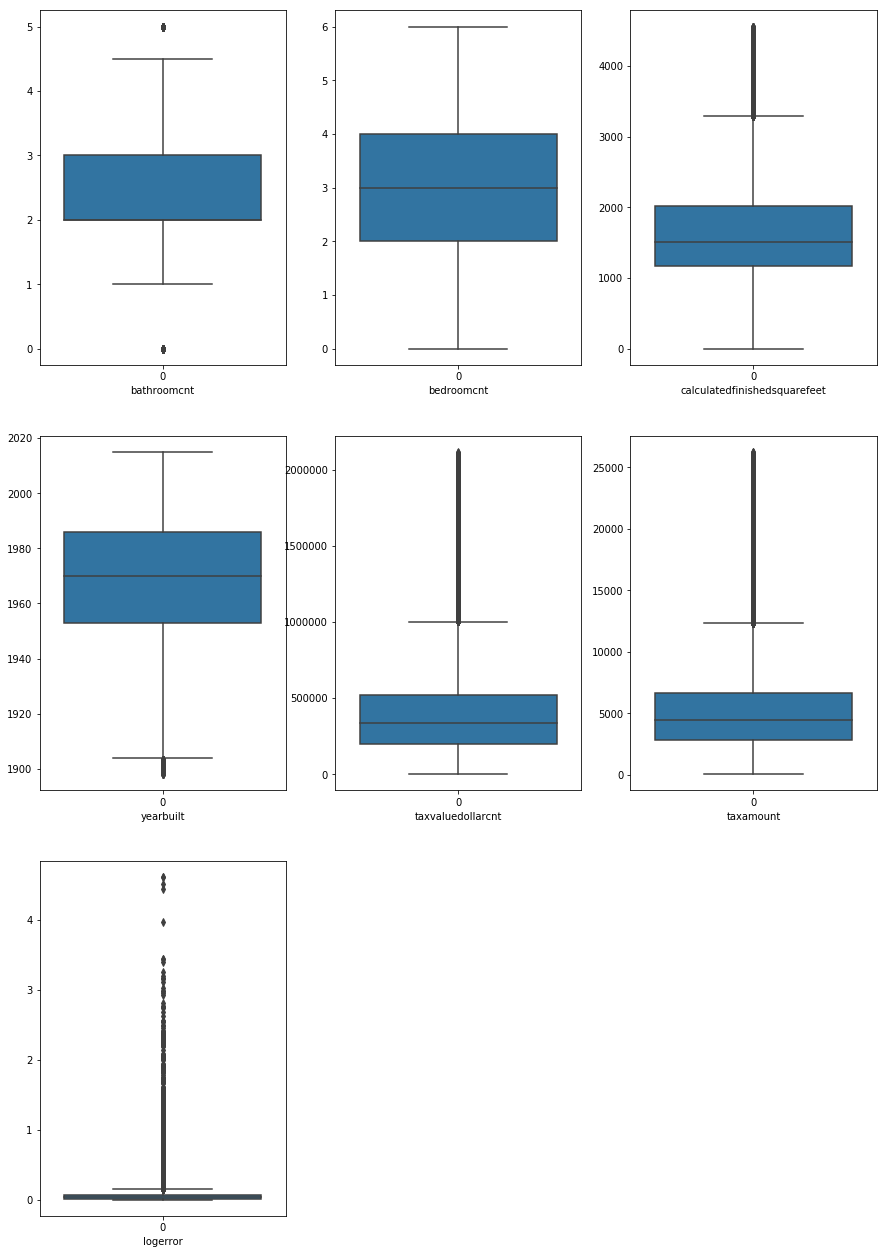

In [99]:
# boxplot the variables
plt.figure(figsize=(15, 30))
for i, var in enumerate(x_vars + ["logerror"]):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(data=df_no_parcelid_dups[var])
    plt.xlabel(var)
    #plt.yscale("log")
plt.show()

**Dependent Variable**
logerror. It is continuous.

**Distribution of numeric variables**

plot a histogram and box plot of each variable.
Why? To see the distribution, skewness, outliers, and unit scales. You will use this information in your decision of whether to normalize, standardize or neither.

In [100]:
# plt.figure(figsize=(15, 30))
# for i, var in enumerate(x_vars):
#     plt.subplot(5, 2, i + 1)
#     sns.distplot(df_no_parcelid_dups[var], kde=False)
#     plt.xlabel(var)
# plt.show()
    
# sns.distplot(df_no_parcelid_dups.logerror)
# plt.show()

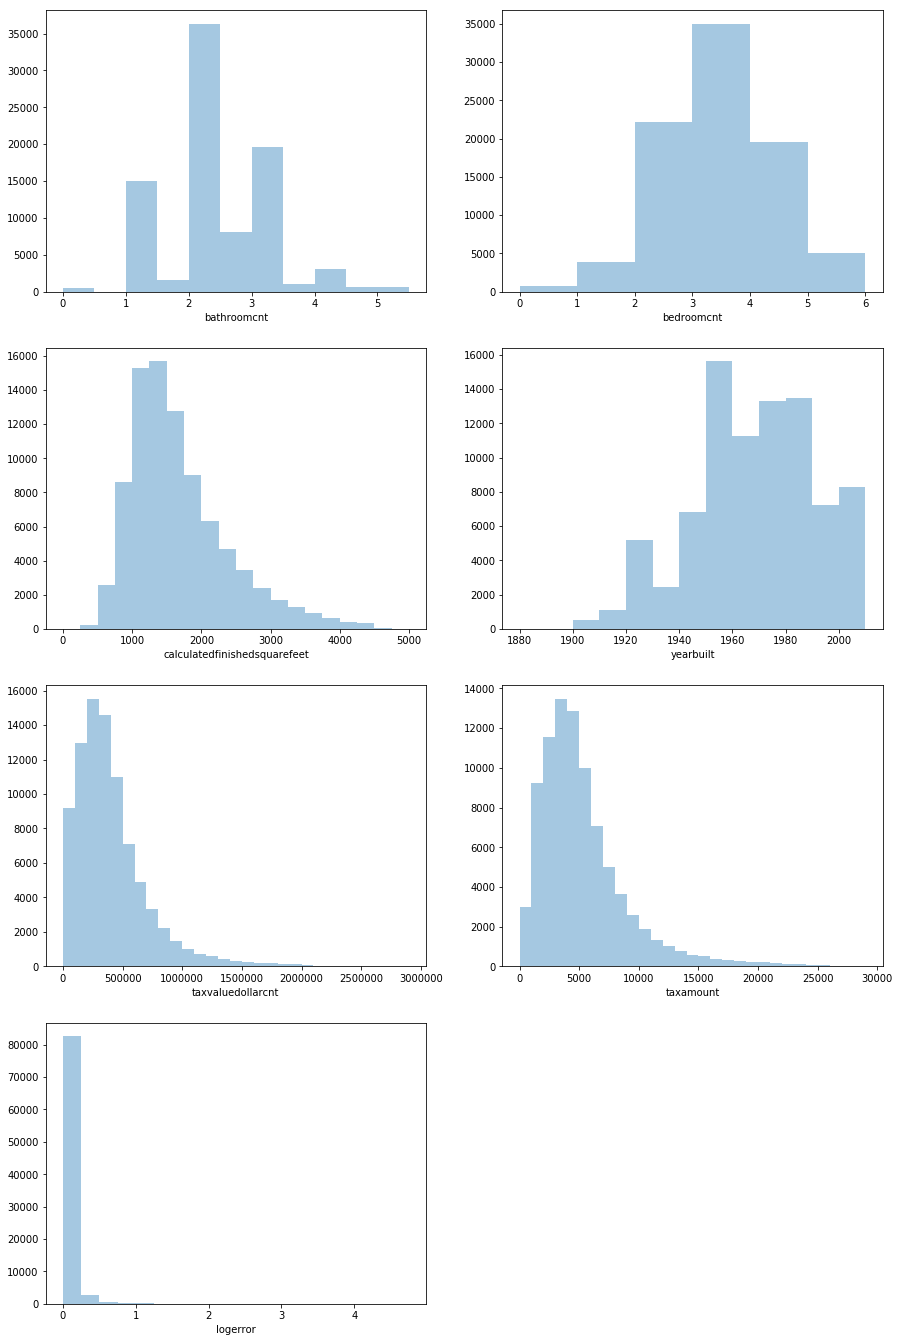

In [101]:
plt.figure(figsize=(15, 30))
# for i, var in enumerate(x_vars):
#     plt.subplot(5, 2, i + 1)
#     sns.distplot(df_no_outliers[var])
#     plt.xlabel(var)
# plt.show()

plt.subplot(521)
bathbins = np.arange(0, 6, 0.5)
sns.distplot(df_no_parcelid_dups.bathroomcnt, bins=bathbins, kde=False)

plt.subplot(522)
bedbins = np.arange(0, 7)
sns.distplot(df_no_parcelid_dups.bedroomcnt, bins=bedbins, kde=False)

plt.subplot(523)
squarefeetbins = np.arange(0, 5250, 250)
sns.distplot(df_no_parcelid_dups.calculatedfinishedsquarefeet, bins=squarefeetbins, kde=False)

plt.subplot(524)
yearbuiltbins = np.arange(1880, 2020, 10)
sns.distplot(df_no_parcelid_dups.yearbuilt, bins=yearbuiltbins, kde=False)

plt.subplot(525)
taxvaluebins=np.arange(0, 3_000_000, 100_000)
sns.distplot(df_no_parcelid_dups.taxvaluedollarcnt, bins=taxvaluebins, kde=False)

plt.subplot(526)
taxamountbins = np.arange(0, 30_000, 1000)
sns.distplot(df_no_parcelid_dups.taxamount, bins=taxamountbins, kde=False)

plt.subplot(527)
logerrorbins = np.arange(0, 5, 0.25)
sns.distplot(df_no_parcelid_dups.logerror, bins=logerrorbins, kde=False)
plt.show()

## Exploration

**Split data into training and test datasets**

In [102]:
X_train, X_test, y_train, y_test = train_test_split(df_no_parcelid_dups[x_vars], df_no_parcelid_dups["logerror"], train_size=0.8, random_state=123)
print(X_train.info())
print()
print(X_test.info())
print()
print(y_train.shape)
print()
print(y_test.shape)
print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69107 entries, 58957 to 16385
Data columns (total 6 columns):
bathroomcnt                     69107 non-null float64
bedroomcnt                      69107 non-null int64
calculatedfinishedsquarefeet    69107 non-null int64
yearbuilt                       69107 non-null int64
taxvaluedollarcnt               69107 non-null int64
taxamount                       69107 non-null float64
dtypes: float64(2), int64(4)
memory usage: 3.7 MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17277 entries, 59939 to 47661
Data columns (total 6 columns):
bathroomcnt                     17277 non-null float64
bedroomcnt                      17277 non-null int64
calculatedfinishedsquarefeet    17277 non-null int64
yearbuilt                       17277 non-null int64
taxvaluedollarcnt               17277 non-null int64
taxamount                       17277 non-null float64
dtypes: float64(2), int64(4)
memory usage: 944.8 KB
None

(69107,)

(17277,)

In [103]:
# X_train = X_train.sample(n=5000, random_state=123)
# y_train = y_train.sample(n=5000, random_state=123)

**Jointplot for each independent variable (normalized version) with the dependent variable**

Pearson's r and p-value annotated on each plot

In [104]:
X_train.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxvaluedollarcnt,taxamount
count,69107.000000,69107.000000,69107.000000,69107.000000,6.910700e+04,69107.000000
mean,2.210514,2.981521,1678.491875,1968.411188,4.017759e+05,5269.208409
std,0.829911,1.007823,714.227777,23.443336,3.024967e+05,3676.099964
min,0.000000,0.000000,2.000000,1898.000000,1.044000e+03,49.080000
25%,2.000000,2.000000,1172.000000,1953.000000,1.960000e+05,2832.855000
50%,2.000000,3.000000,1513.000000,1970.000000,3.363230e+05,4448.150000
75%,3.000000,4.000000,2018.000000,1986.000000,5.192900e+05,6630.320000
max,5.000000,6.000000,4554.000000,2015.000000,2.116779e+06,26260.860000


<Figure size 720x360 with 0 Axes>

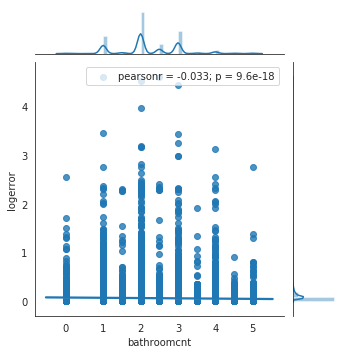

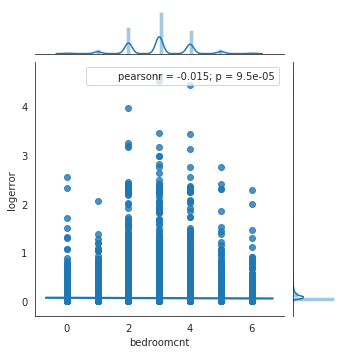

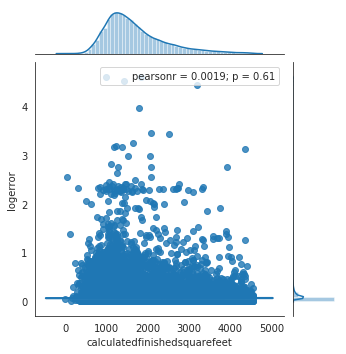

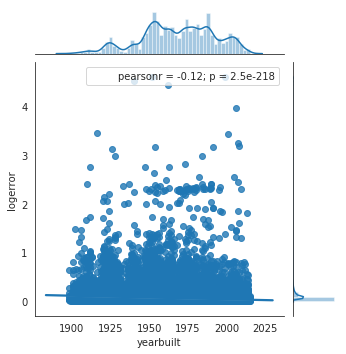

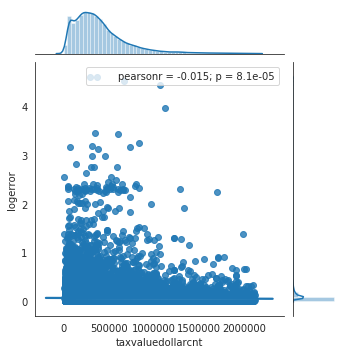

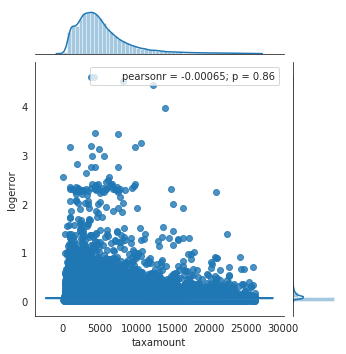

In [105]:
plt.figure(figsize=(10, 5))
with sns.axes_style("white"):
    for i, col in enumerate(x_vars):
        # plt.subplot(3, 1, i + 1)
        j = sns.jointplot(X_train[col], y_train, kind="reg", height=5)
        j.annotate(stats.pearsonr)
plt.show()

1. logerror looks to be worse for houses with bathroomcnt of 1 to 4.
1. logerror looks to be worse for bedroomcnt of 2 to 4.
1. The plots of bathroomcnt and bedroomcnt look similar.
1. Logerror is high for calcualtedfinishedsquarefeet between 1,000 and 3,000
1. yearbuilt has the highest pearsonr, but i don't see a trend.
1. logerror appears to be worse for lower priced homes (less than 500k) and gets better as the value goes up.
1. taxamount has a similar pattern as taxvaluedollarcnt

**Feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent).**

You may want to use a normalized dataframe (if you did that) or adjust the axis scale (set to logarithmic, e.g) so you can more clearly view the interactions.

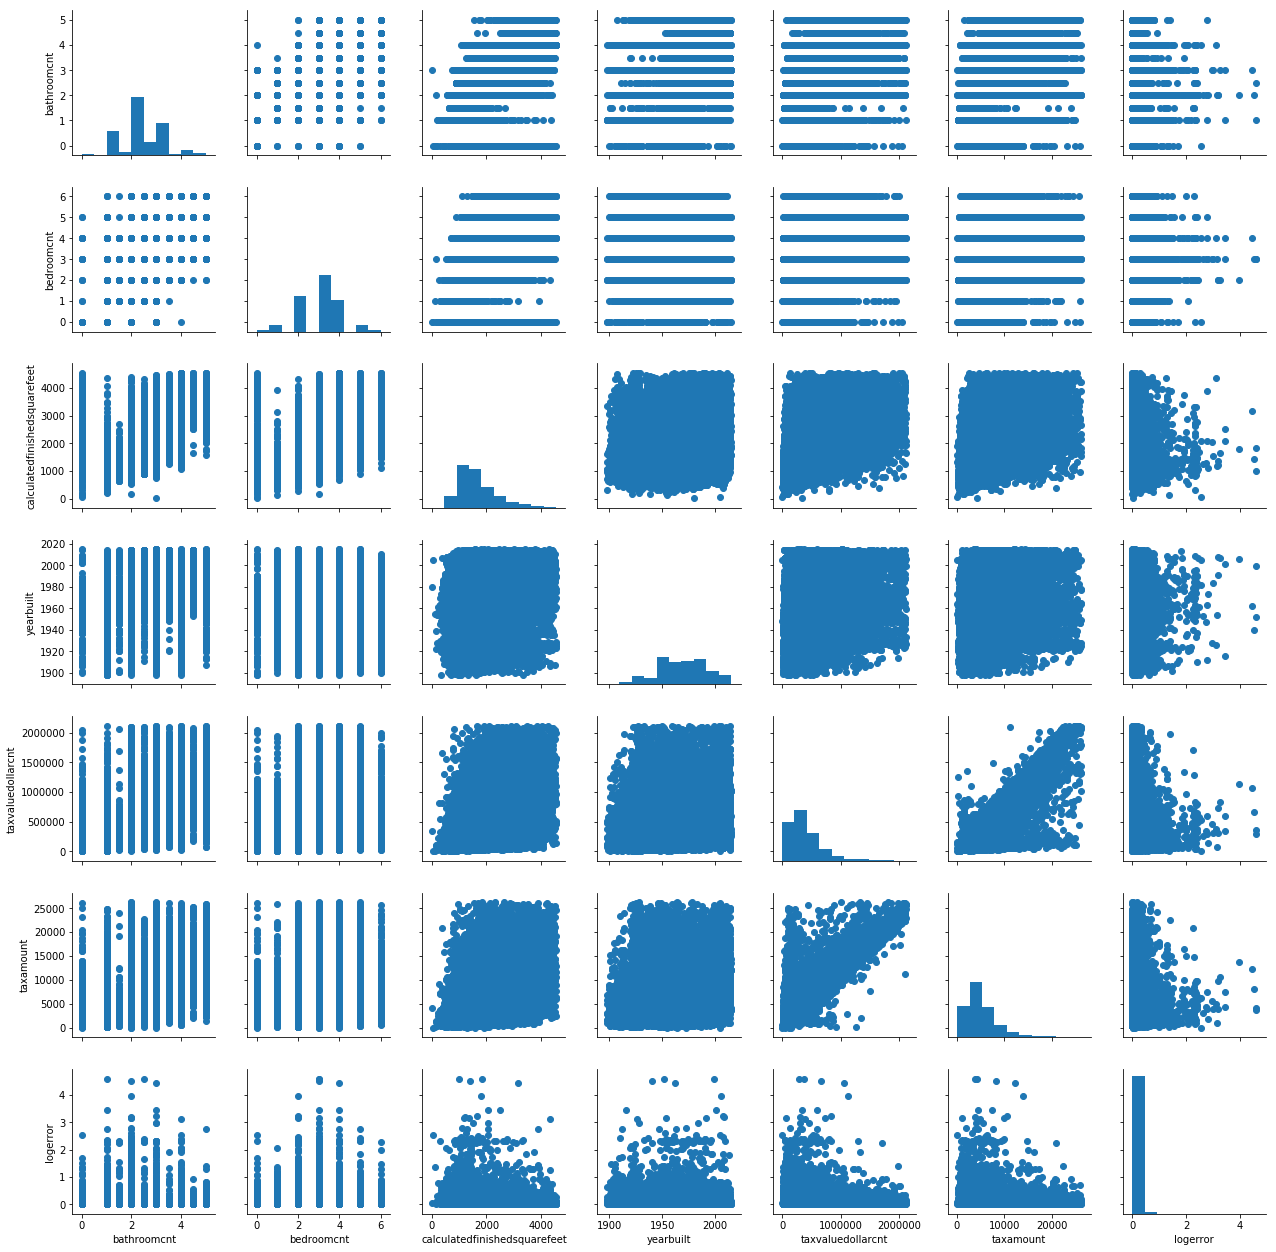

In [106]:
pg = sns.PairGrid(pd.concat([X_train, y_train], axis=1))
pg.map_diag(plt.hist)
pg.map_offdiag(plt.scatter)
plt.show()

1. taxvaluedollarcnt and taxamount appear to have a strong positive linear relationship. (these may be giving the same information)

**Create a heatmap of the correlation between each variable pair.**

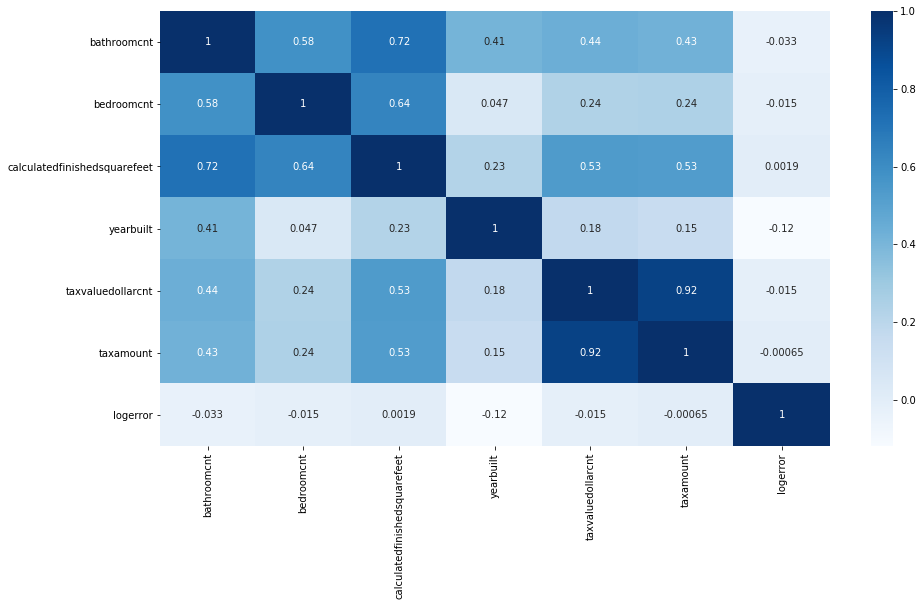

In [107]:
plt.figure(figsize=(15, 8))
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr(), cmap="Blues", annot=True)
plt.show()

In [108]:
df_print_r_and_p_values(X_train[x_vars], y_train)

PEARSON'S R
bathroomcnt:
	Pearson's R is -0.03 with a significance p-value of  9.58e-18

bedroomcnt:
	Pearson's R is -0.01 with a significance p-value of  9.46e-05

calculatedfinishedsquarefeet:
	Pearson's R is 0.00 with a significance p-value of  0.611

yearbuilt:
	Pearson's R is -0.12 with a significance p-value of  2.54e-218

taxvaluedollarcnt:
	Pearson's R is -0.01 with a significance p-value of  8.06e-05

taxamount:
	Pearson's R is -0.00 with a significance p-value of  0.864



1. Bad p-values, consider removing:
    * calculatedfinishedsquarefeet
    * taxamount

In [109]:
for var in x_vars:
    print(f"vs. {var}")
    df_print_r_and_p_values(X_train[x_vars], X_train[var])

vs. bathroomcnt
PEARSON'S R
bathroomcnt:
	Pearson's R is 1.00 with a significance p-value of  0.0

bedroomcnt:
	Pearson's R is 0.58 with a significance p-value of  0.0

calculatedfinishedsquarefeet:
	Pearson's R is 0.72 with a significance p-value of  0.0

yearbuilt:
	Pearson's R is 0.41 with a significance p-value of  0.0

taxvaluedollarcnt:
	Pearson's R is 0.44 with a significance p-value of  0.0

taxamount:
	Pearson's R is 0.43 with a significance p-value of  0.0

vs. bedroomcnt
PEARSON'S R
bathroomcnt:
	Pearson's R is 0.58 with a significance p-value of  0.0

bedroomcnt:
	Pearson's R is 1.00 with a significance p-value of  0.0

calculatedfinishedsquarefeet:
	Pearson's R is 0.64 with a significance p-value of  0.0

yearbuilt:
	Pearson's R is 0.05 with a significance p-value of  3.04e-35

taxvaluedollarcnt:
	Pearson's R is 0.24 with a significance p-value of  0.0

taxamount:
	Pearson's R is 0.24 with a significance p-value of  0.0

vs. calculatedfinishedsquarefeet
PEARSON'S R
bathroo

**Summarize your conclusions from all of these steps.**

I'm not finding any noteworthy correlations, on their own, between any of the independent variables and the dependent. I will have to take a different approach than merely modeling the independent variables on their own.

**Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms?**

Null hypothesis: There is no difference in logerror between houses with 3 bedrooms and houses with 5 or more bedrooms
Alternative hypothesis: There is a difference in logerror between the two groups of houses

I would reject the null hypothesis.

In [110]:
df_train = pd.concat([X_train, y_train], axis=1)
three_beds = df_train[df_train.bedroomcnt == 3].logerror
five_plus_beds = df_train[df_train.bedroomcnt >= 5].logerror
# indep_t_test(three_beds.values, five_plus_beds.values)
print(stats.ttest_ind(three_beds.values, five_plus_beds.values))

Ttest_indResult(statistic=-6.67405628378037, pvalue=2.528700257197018e-11)


**Run a t-test to test this difference.**

**Do the same for another 2 samples you are interested in comparing (e.g. those with 1 bath vs. x baths)**

There is a significant difference in logerror between those houses with one bathroom and those with three bathrooms

In [111]:
# 1 bathroom v. 3 bathrooms
one_bath = df_train[df_train.bathroomcnt == 1].logerror
three_bath = df_train[df_train.bathroomcnt == 3].logerror
# indep_t_test(three_beds.values, five_plus_beds.values)
print(stats.ttest_ind(one_bath.values, three_bath.values))

Ttest_indResult(statistic=13.907214278384439, pvalue=8.045170556858428e-44)


There is a significant difference in logerror between those houses with 500-2,500 square feet and those with 3,500+ square feet.

In [112]:
# 500-2500 square feet
# 3500+ square feeet
small_footage = df_train[
    (df_train.calculatedfinishedsquarefeet >= 500) &
    (df_train.calculatedfinishedsquarefeet <= 2500)
].logerror
large_footage = df_train[df_train.calculatedfinishedsquarefeet >= 3500].logerror
# 
print(stats.ttest_ind(small_footage.values, large_footage.values))

Ttest_indResult(statistic=-5.629000004068838, pvalue=1.820407343765588e-08)


There is a significant difference in logerror between houses with tax value between 100k-250k and 400k-600k


In [113]:
# 100,000 to 250,000 taxvalue
# 400,000 to 600,000
less_expensive = df_train[
    (df_train.taxvaluedollarcnt >= 100_000) &
    (df_train.taxvaluedollarcnt <= 250_000)
].logerror
more_expensive = df_train[
    (df_train.taxvaluedollarcnt >= 400_000) &
    (df_train.taxvaluedollarcnt <= 600_000)].logerror
# 
print(stats.ttest_ind(less_expensive.values, more_expensive.values))

Ttest_indResult(statistic=12.64020313942575, pvalue=1.5567432483288004e-36)


I would reject the null hypothesis that there is no difference in logerror between homes built between 1950 and 1970 and those built between 1990 and 2010

In [114]:
# 1950-1970
# 1990-2010
old = df_train[
    (df_train.yearbuilt >= 1950) &
    (df_train.yearbuilt <= 1970)].logerror
new = df_train[
    (df_train.yearbuilt >= 1990) &
    (df_train.yearbuilt <= 2010)].logerror

print(stats.ttest_ind(new.values, old.values))


Ttest_indResult(statistic=-11.5985489807052, pvalue=4.783037338333661e-31)


## Modeling

### Feature Engineering & Selection

##### feature with bedrooms + baths

In [115]:
X_train_fe = X_train.assign(bathbedcnt=X_train.bathroomcnt + X_train.bedroomcnt)
X_test_fe = X_test.assign(bathbedcnt=X_test.bathroomcnt + X_test.bedroomcnt)

##### feature with taxvalue per square foot

In [116]:
X_train_fe["taxvaluesqft"] = X_train.taxvaluedollarcnt / X_train.calculatedfinishedsquarefeet
X_test_fe["taxvaluesqft"] = X_test.taxvaluedollarcnt / X_test.calculatedfinishedsquarefeet

##### maybe squarefeet per room?

#### Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target

In [117]:
# all variables
ols_model = sm.OLS(y_train, X_train)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     2543.
Date:                Tue, 26 Mar 2019   Prob (F-statistic):               0.00
Time:                        09:02:14   Log-Likelihood:                 37108.
No. Observations:               69107   AIC:                        -7.420e+04
Df Residuals:                   69101   BIC:                        -7.415e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathroomcnt                     -0.0111      0.001    -11.458      0.000      -0.013      -0.009
bedroomcnt                      -0.0018      0.001     -2.429      0.015      -0.003      -0.000
calculatedfinishedsquarefeet  1.277e-05   1.28e-06      9.954      0.000    1.03e-05    1.53e-05
yearbuilt                      3.81e-05   9.24e-07     41.223      0.000    3.63e-05    3.99e-05
taxvaluedollarcnt            -4.569e-08   4.68e-09     -9.770      0.000   -5.49e-08   -3.65e-08
taxamount                      3.36e-06   3.82e-07      8.799      0.000    2.61e-06    4.11e-06
==============================================================================
Omnibus:                   111455.420   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         98881207.032
Skew:                          10.572   Prob(JB):                         0.00
Kurtosis:                     187.101   Cond. No.                     9.39e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [118]:
# all variables
ols_model = sm.OLS(y_train, X_train_fe[["bathbedcnt", "taxvaluesqft", "yearbuilt"]])
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     4993.
Date:                Tue, 26 Mar 2019   Prob (F-statistic):               0.00
Time:                        09:02:14   Log-Likelihood:                 36994.
No. Observations:               69107   AIC:                        -7.398e+04
Df Residuals:                   69104   BIC:                        -7.395e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
bathbedcnt      -0.0020      0.000     -5.947      0.000      -0.003      -0.001
taxvaluesqft -1.225e-06   8.17e-07     -1.500      0.134   -2.83e-06    3.76e-07
yearbuilt     3.883e-05   9.27e-07     41.877      0.000     3.7e-05    4.06e-05
==============================================================================
Omnibus:                   111243.932   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         97577664.843
Skew:                          10.534   Prob(JB):                         0.00
Kurtosis:                     185.876   Cond. No.                     1.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Summarize your conclusions and next steps from your analysis in above. 
What will you try when developing your model? (which features to use/not use/etc)

* I'm seeing a lower r-squared value after feature engineering. It does not appear to be helpful at this point.

### Train & Test Model

#### Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.

#### Univariate regression for each independent variable

Univariate: logerror = 0.08 + -0.00557*bathroomcnt

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.045
	0.11% of the variance in logerror can be explained by bathroomcnt.

P-VALUE
	Train: 9.58e-18

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.045
	0.20% of the variance in logerror can be explained by bathroomcnt.

P-VALUE
	Test: 1.42e-09



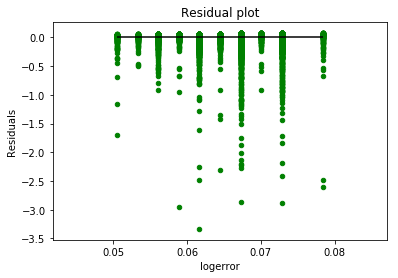

Univariate: logerror = 0.07 + -0.00209*bedroomcnt

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.045
	0.02% of the variance in logerror can be explained by bedroomcnt.

P-VALUE
	Train: 9.46e-05

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.045
	0.00% of the variance in logerror can be explained by bedroomcnt.

P-VALUE
	Test: 0.293



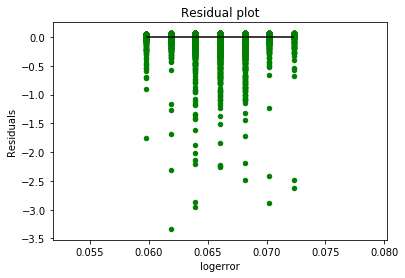

Univariate: logerror = 0.07 + 3.83e-07*calculatedfinishedsquarefeet

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.045
	0.00% of the variance in logerror can be explained by calculatedfinishedsquarefeet.

P-VALUE
	Train: 0.611

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.045
	0.00% of the variance in logerror can be explained by calculatedfinishedsquarefeet.

P-VALUE
	Test: 0.439



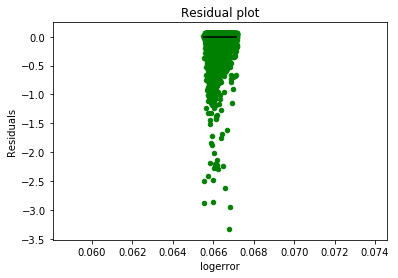

Univariate: logerror = 1.49 + -0.000722*yearbuilt

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.041
	1.43% of the variance in logerror can be explained by yearbuilt.

P-VALUE
	Train: 2.54e-218

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.041
	1.92% of the variance in logerror can be explained by yearbuilt.

P-VALUE
	Test: 8.48e-76



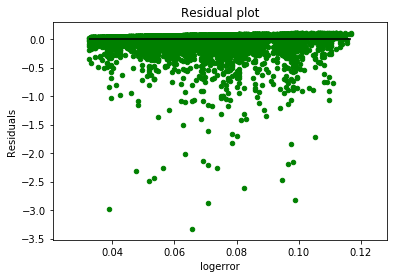

Univariate: logerror = 0.07 + -7.02e-09*taxvaluedollarcnt

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.045
	0.02% of the variance in logerror can be explained by taxvaluedollarcnt.

P-VALUE
	Train: 8.06e-05

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.045
	0.02% of the variance in logerror can be explained by taxvaluedollarcnt.

P-VALUE
	Test: 0.0964



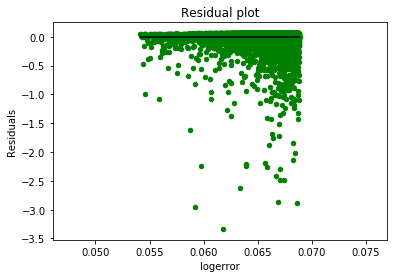

Univariate: logerror = 0.07 + -2.52e-08*taxamount

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.045
	0.00% of the variance in logerror can be explained by taxamount.

P-VALUE
	Train: 0.864

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.045
	-0.00% of the variance in logerror can be explained by taxamount.

P-VALUE
	Test: 0.593



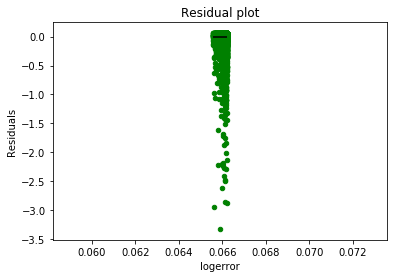

In [119]:
for col in X_train.columns:
    linreg_model(X_train[[col]], y_train.to_frame(), X_test[[col]], y_test.to_frame())

## what is going on here? why is my r-squared 0.178 and its 0.013 from sk-learn model

In [120]:
# all variables
ols_model = sm.OLS(y_train, X_train[["yearbuilt"]])
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                 1.493e+04
Date:                Tue, 26 Mar 2019   Prob (F-statistic):               0.00
Time:                        09:02:16   Log-Likelihood:                 36975.
No. Observations:               69107   AIC:                        -7.395e+04
Df Residuals:                   69106   BIC:                        -7.394e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
yearbuilt   3.346e-05   2.74e-07    122.203      0.000    3.29e-05     3.4e-05
==============================================================================
Omnibus:                   111212.347   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         97345926.446
Skew:                          10.528   Prob(JB):                         0.00
Kurtosis:                     185.657   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### univariate regression on engineered features

Univariate: logerror = 0.08 + -0.00222*bathbedcnt

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.045
	0.07% of the variance in logerror can be explained by bathbedcnt.

P-VALUE
	Train: 1.47e-11

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.045
	0.08% of the variance in logerror can be explained by bathbedcnt.

P-VALUE
	Test: 0.000205



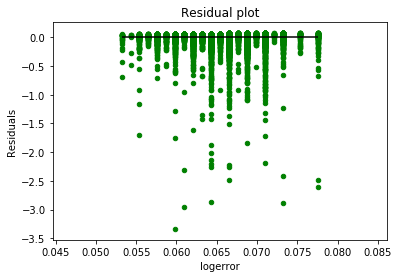

Univariate: logerror = 0.07 + -1.17e-06*taxvaluesqft

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.045
	0.00% of the variance in logerror can be explained by taxvaluesqft.

P-VALUE
	Train: 0.153

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.045
	0.01% of the variance in logerror can be explained by taxvaluesqft.

P-VALUE
	Test: 0.00124



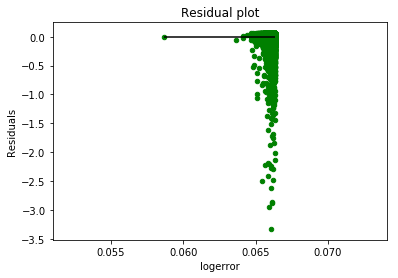

In [121]:
for col in ["bathbedcnt", "taxvaluesqft"]:
    linreg_model(X_train_fe[[col]], y_train.to_frame(), X_test_fe[[col]], y_test.to_frame())

#### Multivariate linear regression models

Multivariate:
logerror = 
1.651
+ 0.00261*bathroomcnt
+ -0.00788*bedroomcnt
+ 1.29e-05*calculatedfinishedsquarefeet
+ -0.000806*yearbuilt
+ -3.75e-08*taxvaluedollarcnt
+ 2.53e-06*taxamount
Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.040
	1.76% of the variance in logerror can be explained by Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'yearbuilt', 'taxvaluedollarcnt', 'taxamount'],
      dtype='object').

P-VALUE
	Train: 9.58e-18

Model Evaluation on TEST Data
	MSE: 0.018
	MAE: 0.041
	2.27% of the variance in logerror can be explained by bathroomcnt.

P-VALUE
	Test: 1.42e-09



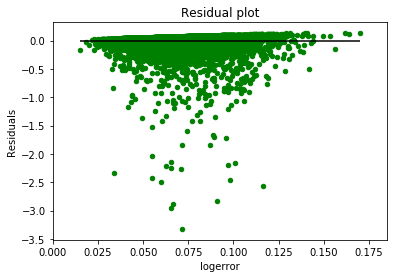

In [122]:
multi_linreg_fit_and_evaluate(X_train, y_train.to_frame(), X_test, y_test.to_frame())

Multivariate:
logerror = 
1.494
+ 0.000237*bathbedcnt
+ -8.36e-07*taxvaluesqft
+ -0.000726*yearbuilt
Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.041
	1.43% of the variance in logerror can be explained by Index(['bathbedcnt', 'taxvaluesqft', 'yearbuilt'], dtype='object').

P-VALUE
	Train: 1.47e-11

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.041
	1.92% of the variance in logerror can be explained by bathbedcnt.

P-VALUE
	Test: 0.000205



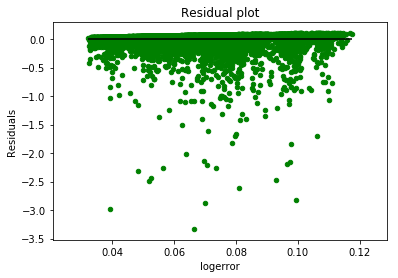

In [123]:
multi_linreg_fit_and_evaluate(X_train_fe[["bathbedcnt", "taxvaluesqft", "yearbuilt"]], y_train.to_frame(), X_test_fe[["bathbedcnt", "taxvaluesqft", "yearbuilt"]], y_test.to_frame())


### Create model for data where bedroomcnt=3 and bedroomcnt=5+

In [124]:
df_train = pd.concat([X_train, y_train], axis=1)
three_beds_train = df_train[df_train.bedroomcnt == 3]
five_plus_beds_train = df_train[df_train.bedroomcnt >= 5]

df_test = pd.concat([X_test, y_test], axis=1)
three_beds_test = df_test[df_test.bedroomcnt == 3]
five_plus_beds_test = df_test[df_test.bedroomcnt >= 5]

Univariate: logerror = 0.08 + -0.00799*bathroomcnt

Model Evaluation on TRAIN Data
	MSE: 0.019
	MAE: 0.041
	0.15% of the variance in logerror can be explained by bathroomcnt.

P-VALUE
	Train: 1.46e-10

Model Evaluation on TEST Data
	MSE: 0.014
	MAE: 0.042
	0.08% of the variance in logerror can be explained by bathroomcnt.

P-VALUE
	Test: 0.00712



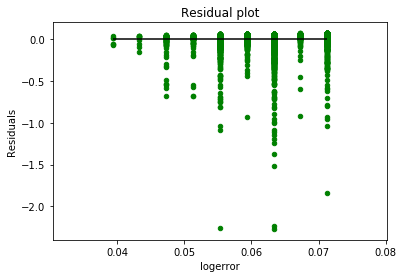

Univariate: logerror = 0.06 + 0.0*bedroomcnt

Model Evaluation on TRAIN Data
	MSE: 0.019
	MAE: 0.042
	0.00% of the variance in logerror can be explained by bedroomcnt.

P-VALUE
	Train: nan

Model Evaluation on TEST Data
	MSE: 0.014
	MAE: 0.042
	-0.01% of the variance in logerror can be explained by bedroomcnt.

P-VALUE
	Test: nan



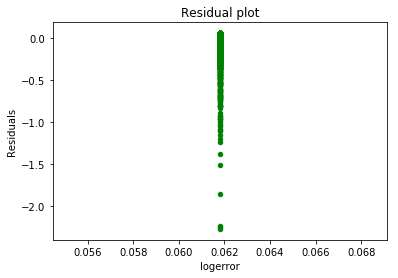

Univariate: logerror = 0.06 + 8.91e-10*calculatedfinishedsquarefeet

Model Evaluation on TRAIN Data
	MSE: 0.019
	MAE: 0.042
	0.00% of the variance in logerror can be explained by calculatedfinishedsquarefeet.

P-VALUE
	Train: 1.0

Model Evaluation on TEST Data
	MSE: 0.014
	MAE: 0.042
	-0.01% of the variance in logerror can be explained by calculatedfinishedsquarefeet.

P-VALUE
	Test: 0.0413



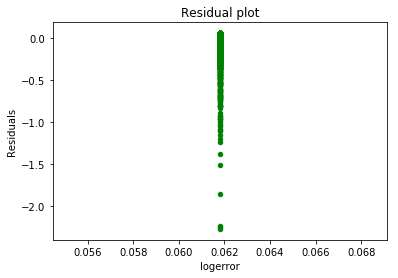

Univariate: logerror = 1.24 + -0.000597*yearbuilt

Model Evaluation on TRAIN Data
	MSE: 0.018
	MAE: 0.039
	0.96% of the variance in logerror can be explained by yearbuilt.

P-VALUE
	Train: 4.15e-61

Model Evaluation on TEST Data
	MSE: 0.014
	MAE: 0.039
	1.41% of the variance in logerror can be explained by yearbuilt.

P-VALUE
	Test: 1.88e-23



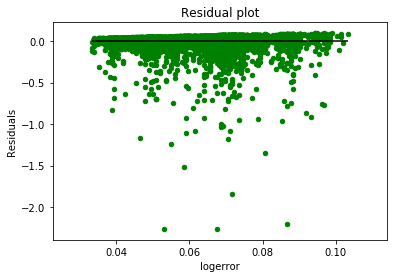

Univariate: logerror = 0.07 + -8.82e-09*taxvaluedollarcnt

Model Evaluation on TRAIN Data
	MSE: 0.019
	MAE: 0.042
	0.03% of the variance in logerror can be explained by taxvaluedollarcnt.

P-VALUE
	Train: 0.00203

Model Evaluation on TEST Data
	MSE: 0.014
	MAE: 0.042
	-0.06% of the variance in logerror can be explained by taxvaluedollarcnt.

P-VALUE
	Test: 0.962



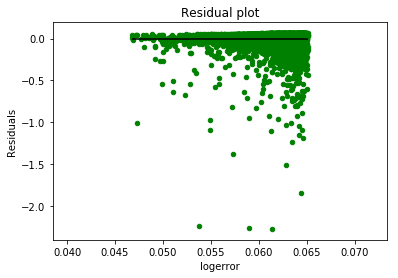

Univariate: logerror = 0.06 + -2.27e-07*taxamount

Model Evaluation on TRAIN Data
	MSE: 0.019
	MAE: 0.042
	0.00% of the variance in logerror can be explained by taxamount.

P-VALUE
	Train: 0.335

Model Evaluation on TEST Data
	MSE: 0.014
	MAE: 0.042
	-0.04% of the variance in logerror can be explained by taxamount.

P-VALUE
	Test: 0.12



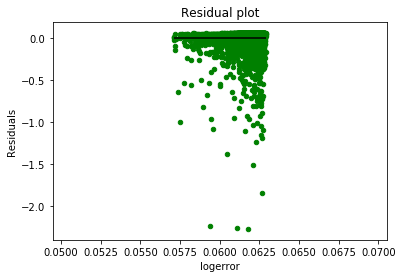

Univariate: logerror = -0.00 + 1.0*logerror

Model Evaluation on TRAIN Data
	MSE: 0.000
	MAE: 0.000
	100.00% of the variance in logerror can be explained by logerror.

P-VALUE
	Train: 0.0

Model Evaluation on TEST Data
	MSE: 0.000
	MAE: 0.000
	100.00% of the variance in logerror can be explained by logerror.

P-VALUE
	Test: 0.0



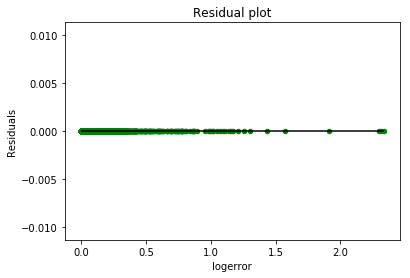

In [125]:
for col in three_beds_train.columns:
    linreg_model(three_beds_train[[col]], three_beds_train[["logerror"]], three_beds_test[[col]], three_beds_test[["logerror"]])

Univariate: logerror = 0.06 + 0.00413*bathroomcnt

Model Evaluation on TRAIN Data
	MSE: 0.023
	MAE: 0.054
	0.05% of the variance in logerror can be explained by bathroomcnt.

P-VALUE
	Train: 0.142

Model Evaluation on TEST Data
	MSE: 0.034
	MAE: 0.053
	-0.10% of the variance in logerror can be explained by bathroomcnt.

P-VALUE
	Test: 0.864



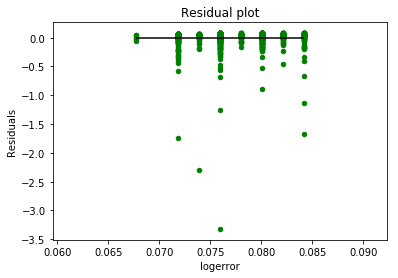

Univariate: logerror = -0.12 + 0.0392*bedroomcnt

Model Evaluation on TRAIN Data
	MSE: 0.023
	MAE: 0.053
	0.87% of the variance in logerror can be explained by bedroomcnt.

P-VALUE
	Train: 2.81e-09

Model Evaluation on TEST Data
	MSE: 0.034
	MAE: 0.052
	1.12% of the variance in logerror can be explained by bedroomcnt.

P-VALUE
	Test: 0.000397



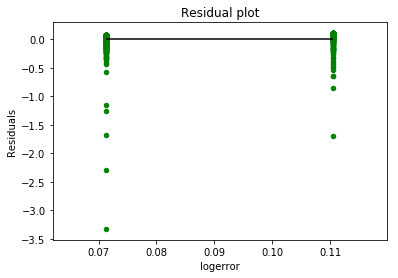

Univariate: logerror = 0.08 + 5.28e-07*calculatedfinishedsquarefeet

Model Evaluation on TRAIN Data
	MSE: 0.023
	MAE: 0.054
	0.00% of the variance in logerror can be explained by calculatedfinishedsquarefeet.

P-VALUE
	Train: 0.873

Model Evaluation on TEST Data
	MSE: 0.034
	MAE: 0.055
	-0.04% of the variance in logerror can be explained by calculatedfinishedsquarefeet.

P-VALUE
	Test: 0.869



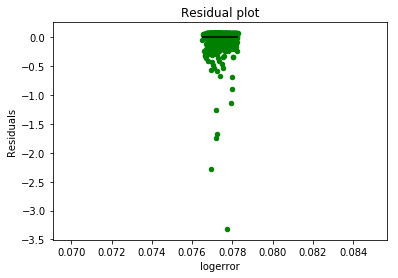

Univariate: logerror = 1.78 + -0.000866*yearbuilt

Model Evaluation on TRAIN Data
	MSE: 0.022
	MAE: 0.046
	2.38% of the variance in logerror can be explained by yearbuilt.

P-VALUE
	Train: 5.83e-23

Model Evaluation on TEST Data
	MSE: 0.033
	MAE: 0.047
	2.63% of the variance in logerror can be explained by yearbuilt.

P-VALUE
	Test: 6.18e-08



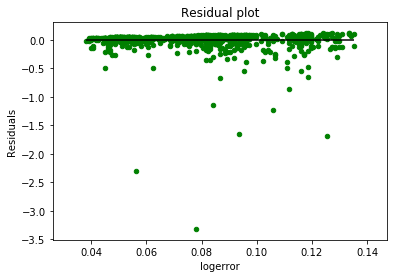

Univariate: logerror = 0.09 + -1.57e-08*taxvaluedollarcnt

Model Evaluation on TRAIN Data
	MSE: 0.023
	MAE: 0.054
	0.17% of the variance in logerror can be explained by taxvaluedollarcnt.

P-VALUE
	Train: 0.00831

Model Evaluation on TEST Data
	MSE: 0.034
	MAE: 0.054
	0.04% of the variance in logerror can be explained by taxvaluedollarcnt.

P-VALUE
	Test: 0.353



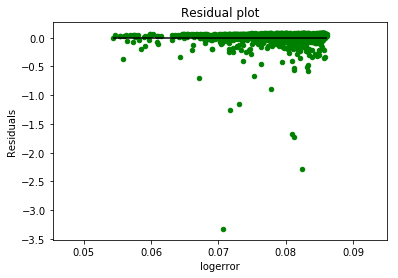

Univariate: logerror = 0.09 + -1.12e-06*taxamount

Model Evaluation on TRAIN Data
	MSE: 0.023
	MAE: 0.054
	0.12% of the variance in logerror can be explained by taxamount.

P-VALUE
	Train: 0.0251

Model Evaluation on TEST Data
	MSE: 0.034
	MAE: 0.054
	0.06% of the variance in logerror can be explained by taxamount.

P-VALUE
	Test: 0.307



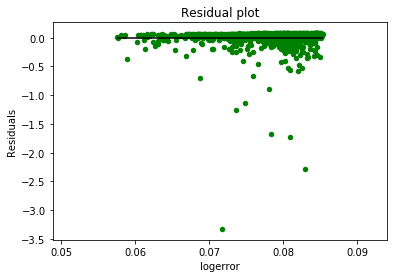

Univariate: logerror = 0.00 + 1.0*logerror

Model Evaluation on TRAIN Data
	MSE: 0.000
	MAE: 0.000
	100.00% of the variance in logerror can be explained by logerror.

P-VALUE
	Train: 0.0

Model Evaluation on TEST Data
	MSE: 0.000
	MAE: 0.000
	100.00% of the variance in logerror can be explained by logerror.

P-VALUE
	Test: 0.0



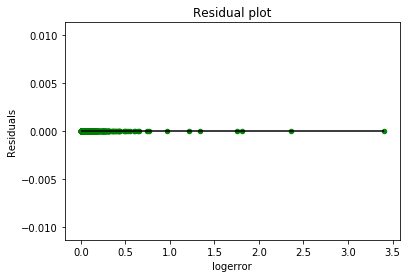

In [126]:
for col in five_plus_beds_train.columns:
    linreg_model(five_plus_beds_train[[col]], five_plus_beds_train[["logerror"]], five_plus_beds_test[[col]], five_plus_beds_test[["logerror"]])

#### Predict & evaluate on out-of-sample data (test)    

- Plot the residuals from your out-of-sample predictions.

- Summarize your expectations about how you estimate this model will perform in production.

## Normalization

In [136]:
# Normalize all columns in train and test data
cols_to_norm = ("bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet", "yearbuilt",
                "taxvaluedollarcnt", "taxamount")
X_train_norm, X_test_norm = normalize_cols(X_train, X_test, cols_to_norm)
# print(df_peek(X_train_norm))
# print(df_peek(X_test_norm))

<Figure size 720x360 with 0 Axes>

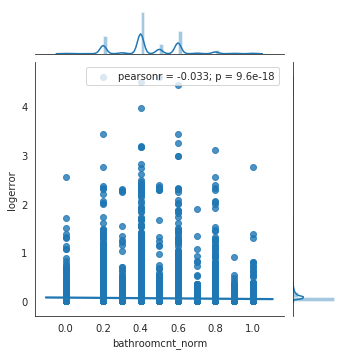

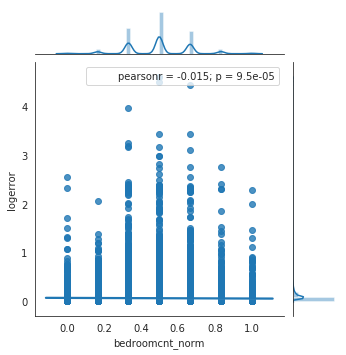

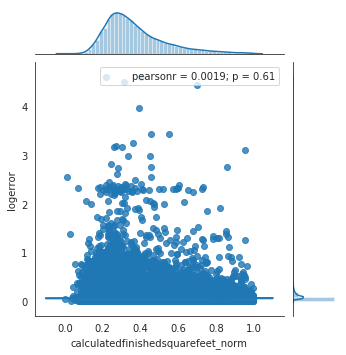

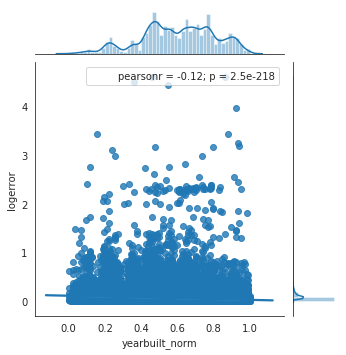

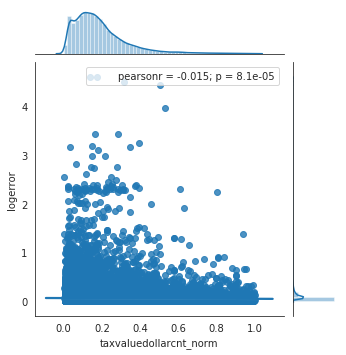

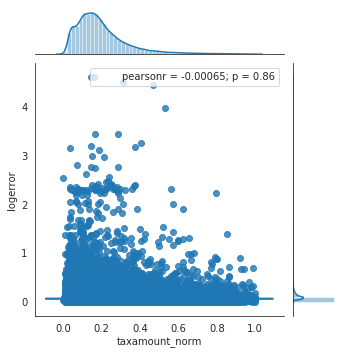

In [137]:
plt.figure(figsize=(10, 5))
with sns.axes_style("white"):
    for col in X_train_norm.columns:
        # plt.subplot(3, 1, i + 1)
        j = sns.jointplot(X_train_norm[col], y_train, kind="reg", height=5)
        j.annotate(stats.pearsonr)
plt.show()

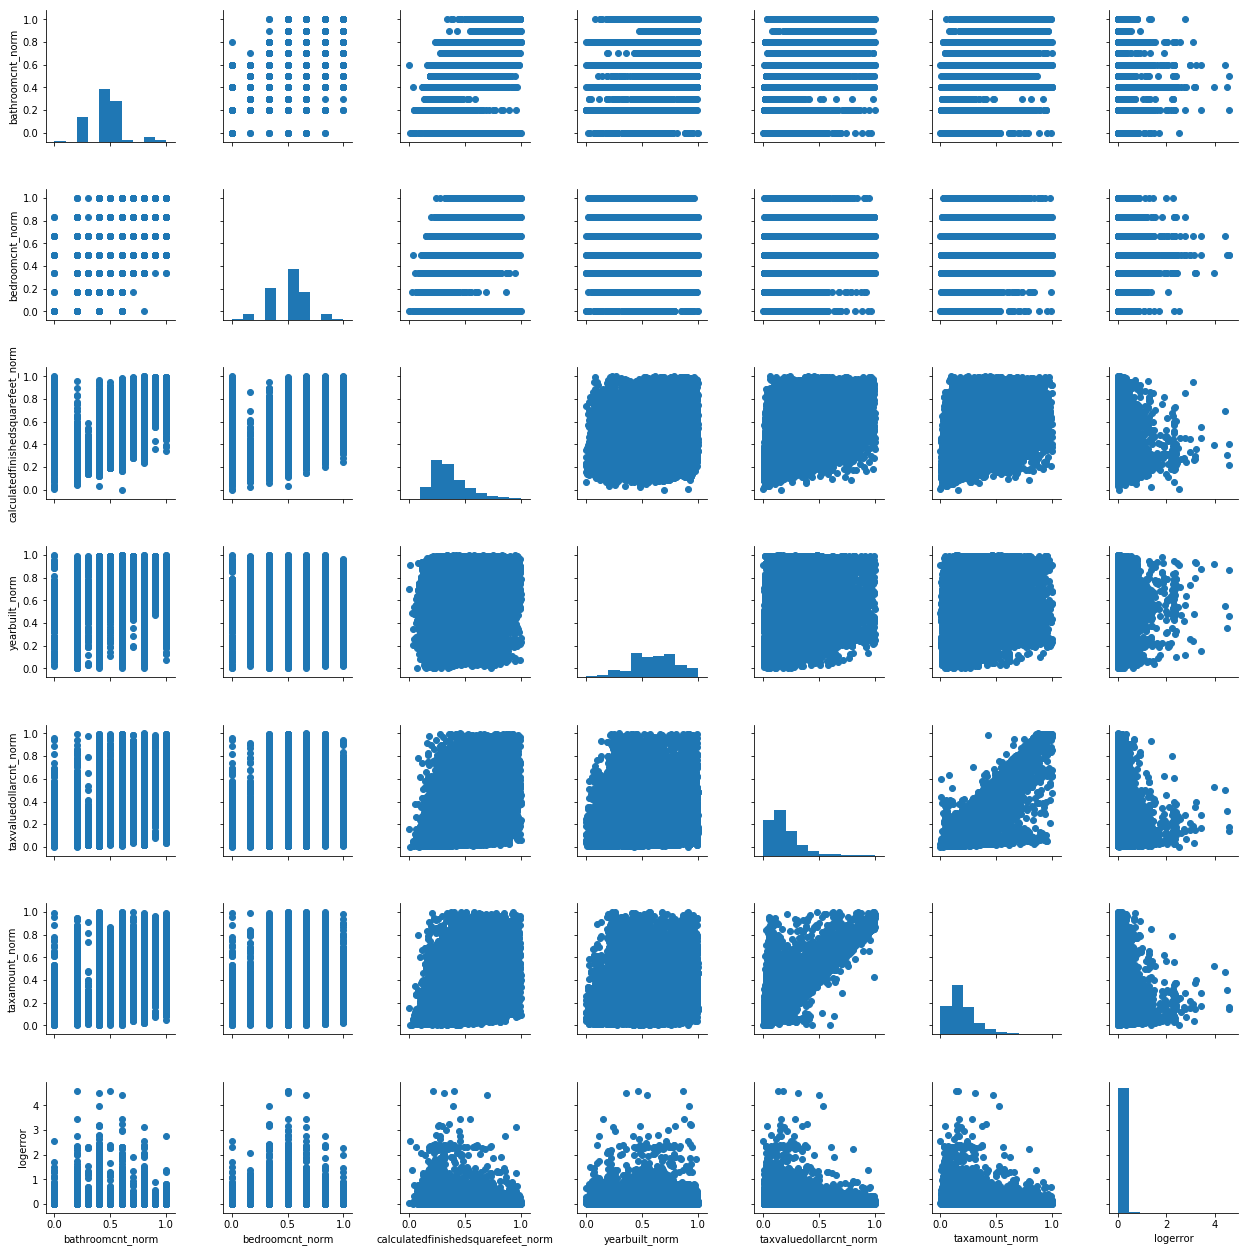

In [138]:
pg = sns.PairGrid(pd.concat([X_train_norm, y_train], axis=1))
pg.map_diag(plt.hist)
pg.map_offdiag(plt.scatter)
plt.show()

In [139]:
df_print_r_and_p_values(X_train_norm, y_train)

PEARSON'S R
bathroomcnt_norm:
	Pearson's R is -0.03 with a significance p-value of  9.58e-18

bedroomcnt_norm:
	Pearson's R is -0.01 with a significance p-value of  9.46e-05

calculatedfinishedsquarefeet_norm:
	Pearson's R is 0.00 with a significance p-value of  0.611

yearbuilt_norm:
	Pearson's R is -0.12 with a significance p-value of  2.54e-218

taxvaluedollarcnt_norm:
	Pearson's R is -0.01 with a significance p-value of  8.06e-05

taxamount_norm:
	Pearson's R is -0.00 with a significance p-value of  0.864



In [140]:
# all variables
ols_model = sm.OLS(y_train, X_train_norm)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     2204.
Date:                Tue, 26 Mar 2019   Prob (F-statistic):               0.00
Time:                        09:05:17   Log-Likelihood:                 36267.
No. Observations:               69107   AIC:                        -7.252e+04
Df Residuals:                   69101   BIC:                        -7.247e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
bathroomcnt_norm                     -0.0017      0.005     -0.317      0.751      -0.012       0.009
bedroomcnt_norm                       0.0746      0.004     19.215      0.000       0.067       0.082
calculatedfinishedsquarefeet_norm     0.0456      0.006      7.719      0.000       0.034       0.057
yearbuilt_norm                        0.0053      0.002      2.206      0.027       0.001       0.010
taxvaluedollarcnt_norm               -0.1149      0.010    -11.480      0.000      -0.134      -0.095
taxamount_norm                        0.1251      0.010     12.390      0.000       0.105       0.145
==============================================================================
Omnibus:                   109700.147   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         90417825.757
Skew:                          10.249   Prob(JB):                         0.00
Kurtosis:                     179.014   Cond. No.                         26.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Univariate: logerror = 0.08 + -0.0278*bathroomcnt_norm

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.045
	0.11% of the variance in logerror can be explained by bathroomcnt_norm.

P-VALUE
	Train: 9.58e-18

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.045
	0.20% of the variance in logerror can be explained by bathroomcnt_norm.

P-VALUE
	Test: 1.42e-09



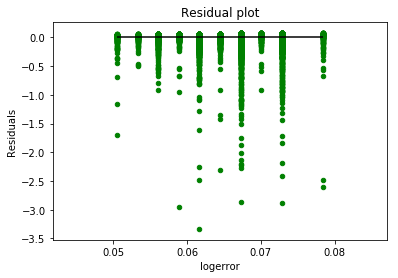

Univariate: logerror = 0.07 + -0.0125*bedroomcnt_norm

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.045
	0.02% of the variance in logerror can be explained by bedroomcnt_norm.

P-VALUE
	Train: 9.46e-05

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.045
	0.00% of the variance in logerror can be explained by bedroomcnt_norm.

P-VALUE
	Test: 0.293



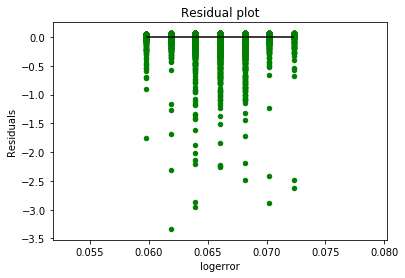

Univariate: logerror = 0.07 + 0.00175*calculatedfinishedsquarefeet_norm

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.045
	0.00% of the variance in logerror can be explained by calculatedfinishedsquarefeet_norm.

P-VALUE
	Train: 0.611

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.045
	0.00% of the variance in logerror can be explained by calculatedfinishedsquarefeet_norm.

P-VALUE
	Test: 0.439



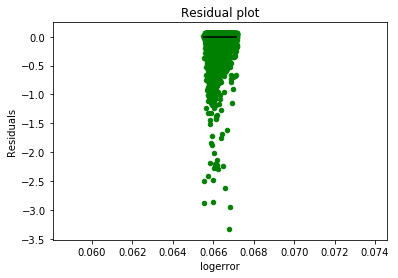

Univariate: logerror = 0.12 + -0.0845*yearbuilt_norm

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.041
	1.43% of the variance in logerror can be explained by yearbuilt_norm.

P-VALUE
	Train: 2.54e-218

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.041
	1.92% of the variance in logerror can be explained by yearbuilt_norm.

P-VALUE
	Test: 8.48e-76



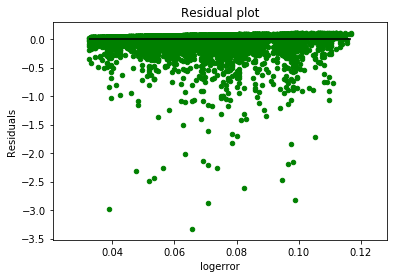

Univariate: logerror = 0.07 + -0.0149*taxvaluedollarcnt_norm

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.045
	0.02% of the variance in logerror can be explained by taxvaluedollarcnt_norm.

P-VALUE
	Train: 8.06e-05

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.045
	0.02% of the variance in logerror can be explained by taxvaluedollarcnt_norm.

P-VALUE
	Test: 0.0964



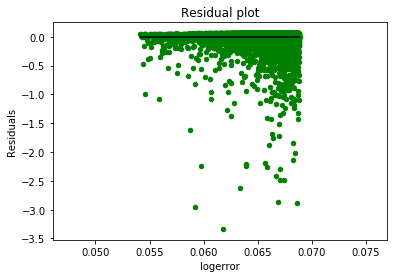

Univariate: logerror = 0.07 + -0.00066*taxamount_norm

Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.045
	0.00% of the variance in logerror can be explained by taxamount_norm.

P-VALUE
	Train: 0.864

Model Evaluation on TEST Data
	MSE: 0.019
	MAE: 0.045
	-0.00% of the variance in logerror can be explained by taxamount_norm.

P-VALUE
	Test: 0.593



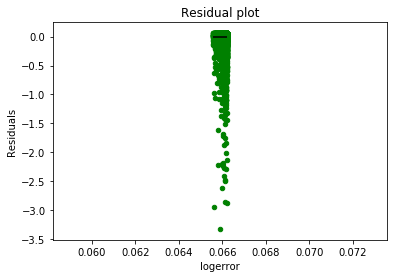

In [141]:
for col in X_train_norm.columns:
    linreg_model(X_train_norm[[col]], y_train.to_frame(), X_test_norm[[col]], y_test.to_frame())

Multivariate:
logerror = 
0.121
+ 0.0131*bathroomcnt_norm
+ -0.0473*bedroomcnt_norm
+ 0.0585*calculatedfinishedsquarefeet_norm
+ -0.0943*yearbuilt_norm
+ -0.0793*taxvaluedollarcnt_norm
+ 0.0664*taxamount_norm
Model Evaluation on TRAIN Data
	MSE: 0.020
	MAE: 0.040
	1.76% of the variance in logerror can be explained by Index(['bathroomcnt_norm', 'bedroomcnt_norm',
       'calculatedfinishedsquarefeet_norm', 'yearbuilt_norm',
       'taxvaluedollarcnt_norm', 'taxamount_norm'],
      dtype='object').

P-VALUE
	Train: 9.58e-18

Model Evaluation on TEST Data
	MSE: 0.018
	MAE: 0.041
	2.27% of the variance in logerror can be explained by bathroomcnt_norm.

P-VALUE
	Test: 1.42e-09



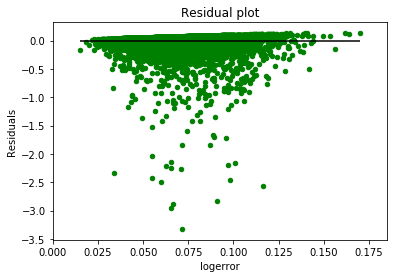

In [142]:
multi_linreg_fit_and_evaluate(X_train_norm, y_train.to_frame(), X_test_norm, y_test.to_frame())

### Bin Data

In [143]:
# Create range for your new columns
yearbuilt_range = zip(range(1900, 2020, 10), range(1910, 2030, 10))

new_df = pd.DataFrame()

# Iterate and create new columns, with the 0 and 1 encoding
for r in yearbuilt_range:
    new_df["yearbuilt_%d_to_%d" % r] = X_train["yearbuilt"].apply(
    lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)

new_df


,yearbuilt_1900_to_1910,yearbuilt_1910_to_1920,yearbuilt_1920_to_1930,yearbuilt_1930_to_1940,yearbuilt_1940_to_1950,yearbuilt_1950_to_1960,yearbuilt_1960_to_1970,yearbuilt_1970_to_1980,yearbuilt_1980_to_1990,yearbuilt_1990_to_2000,yearbuilt_2000_to_2010,yearbuilt_2010_to_2020
58957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
27751,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
78472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
60552,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
48003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15515,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
82168,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79607,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
